In [32]:
'''
Train PredNet on KITTI sequences. (Geiger et al. 2013, http://www.cvlibs.net/datasets/kitti/)
'''

import os
import numpy as np
np.random.seed(123)
from six.moves import cPickle

import keras

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

from prednet import PredNet
# from data_utils import SequenceGenerator
from kitti_settings import *

import os
import numpy as np
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
import time

from data_utils import SequenceGenerator

In [2]:
import hickle as hkl
import numpy as np
from keras import backend as K
from keras.preprocessing.image import Iterator

# Data generator that creates sequences for input into PredNet.

In [3]:
SCALAR = 80
image_size = 512

raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))
RAD_id_list = raw_RAD_id_list

5000


In [29]:
def check_RAD_id(RAD_id):
    sum_list = []
    for k in range(61):
        sum_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().sum())
    sum_list = np.array(sum_list)
    if i % 100 == 0:
        print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
        print(i, sum_list[:7])
    if sum_list.mean() < 251001 * 0:
        return False
    for k in range(59):
        if abs(sum_list[k] + sum_list[k + 2] - 2 * sum_list[k + 1]) > 251001 * 2:
            return False
    return True

In [33]:
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = []
for (i, RAD_id) in enumerate(raw_RAD_id_list[:100]):
    if check_RAD_id(RAD_id):
        RAD_id_list.append(RAD_id)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

start time: 2018-08-24 12:26:13
00:00:00
0 [-218731 -223051 -219804 -220007 -214895 -215379 -215980]
end time: 2018-08-24 12:26:18
00:00:05
36


In [34]:
RAD_id = RAD_id_list[0]

In [ ]:
class SequenceGenerator(Iterator):
    def __init__(self, data_file, source_file, nt,
                 batch_size=8, shuffle=False, seed=None,
                 output_mode='error', sequence_start_mode='all', N_seq=None,
                 data_format=K.image_data_format()):
#         self.X = hkl.load(data_file)  # X will be like (n_images, nb_cols, nb_rows, nb_channels)
#         self.sources = hkl.load(source_file) # source for each image so when creating sequences can assure that consecutive frames are from same video

#         x_matrix = np.empty((31, image_size, image_size, 1))
#         for i in range(31):
#             x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
#         y_matrix = np.empty((30, image_size, image_size, 1))
#         for i in range(30):
#             y_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + 31)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
        self.X = x_matrix
        self.sources = y_matrix
        self.nt = nt
        self.batch_size = batch_size
        self.data_format = data_format
        assert sequence_start_mode in {'all', 'unique'}, 'sequence_start_mode must be in {all, unique}'
        self.sequence_start_mode = sequence_start_mode
        assert output_mode in {'error', 'prediction'}, 'output_mode must be in {error, prediction}'
        self.output_mode = output_mode

        if self.data_format == 'channels_first':
            self.X = np.transpose(self.X, (0, 3, 1, 2))
        self.im_shape = self.X[0].shape

        if self.sequence_start_mode == 'all':  # allow for any possible sequence, starting from any frame
            self.possible_starts = np.array([i for i in range(self.X.shape[0] - self.nt) if self.sources[i] == self.sources[i + self.nt - 1]])
        elif self.sequence_start_mode == 'unique':  #create sequences where each unique frame is in at most one sequence
            curr_location = 0
            possible_starts = []
            while curr_location < self.X.shape[0] - self.nt + 1:
                if self.sources[curr_location] == self.sources[curr_location + self.nt - 1]:
                    possible_starts.append(curr_location)
                    curr_location += self.nt
                else:
                    curr_location += 1
            self.possible_starts = possible_starts

        if shuffle:
            self.possible_starts = np.random.permutation(self.possible_starts)
        if N_seq is not None and len(self.possible_starts) > N_seq:  # select a subset of sequences if want to
            self.possible_starts = self.possible_starts[:N_seq]
        self.N_sequences = len(self.possible_starts)
        super(SequenceGenerator, self).__init__(len(self.possible_starts), batch_size, shuffle, seed)

    def next(self):
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        batch_x = np.zeros((current_batch_size, self.nt) + self.im_shape, np.float32)
        for i, idx in enumerate(index_array):
            idx = self.possible_starts[idx]
            batch_x[i] = self.preprocess(self.X[idx:idx+self.nt])
        if self.output_mode == 'error':  # model outputs errors, so y should be zeros
            batch_y = np.zeros(current_batch_size, np.float32)
        elif self.output_mode == 'prediction':  # output actual pixels
            batch_y = batch_x
        return batch_x, batch_y

    def preprocess(self, X):
        return X.astype(np.float32) / 255

    def create_all(self):
        X_all = np.zeros((self.N_sequences, self.nt) + self.im_shape, np.float32)
        for i, idx in enumerate(self.possible_starts):
            X_all[i] = self.preprocess(self.X[idx:idx+self.nt])
        return X_all

In [ ]:
RAD_id = RAD_id_list[0]
SCALAR = 80
size = 512

In [ ]:
a = PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 0))

In [ ]:
a.shape

In [ ]:
K.image_data_format()

In [57]:
save_model = True  # if weights will be saved
weights_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')  # where weights will be saved
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

# Data files
train_file = os.path.join(DATA_DIR, 'X_train.hkl')
train_sources = os.path.join(DATA_DIR, 'sources_train.hkl')
val_file = os.path.join(DATA_DIR, 'X_val.hkl')
val_sources = os.path.join(DATA_DIR, 'sources_val.hkl')

# Training parameters
nb_epoch = 15
batch_size = 4
samples_per_epoch = 50  # 500
N_seq_val = 10  # 100  number of sequences to use for validation

# Model parameters
n_channels, im_height, im_width = (1, image_size, image_size)  # (3, 128, 160)
input_shape = (n_channels, im_height, im_width) if K.image_data_format() == 'channels_first' else (im_height, im_width, n_channels)
stack_sizes = (n_channels, 48, 96)  # (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (3, 3)
Ahat_filt_sizes = (3, 3, 3)
R_filt_sizes = (3, 3, 3)
layer_loss_weights = np.array([1., 0., 0., 0.])  # weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
nt = 10  # number of timesteps used for sequences in training
time_loss_weights = 1./ (nt - 1) * np.ones((nt,1))  # equally weight all timesteps except the first
time_loss_weights[0] = 0


prednet = PredNet(stack_sizes, R_stack_sizes,
                  A_filt_sizes, Ahat_filt_sizes, R_filt_sizes, A_activation='elu', error_activation='elu',
                  output_mode='prediction', return_sequences=False)

inputs = Input(shape=(nt,) + input_shape)
outputs = prednet(inputs)
# errors = prednet(inputs)  # errors will be (batch_size, nt, nb_layers)
# errors_by_time = TimeDistributed(Dense(1, trainable=False), weights=[layer_loss_weights, np.zeros(1)], trainable=False)(errors)  # calculate weighted error by layer
# errors_by_time = Flatten()(errors_by_time)  # will be (batch_size, nt)
# final_errors = Dense(1, weights=[time_loss_weights, np.zeros(1)], trainable=False)(errors_by_time)  # weight errors by time
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(lr=0.0003))

In [ ]:
final_errors

In [ ]:
train_generator = SequenceGenerator(train_file, train_sources, nt, batch_size=batch_size, shuffle=True)
val_generator = SequenceGenerator(val_file, val_sources, nt, batch_size=batch_size, N_seq=N_seq_val)

lr_schedule = lambda epoch: 0.001 if epoch < 75 else 0.0001    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
callbacks = [LearningRateScheduler(lr_schedule)]
if save_model:
    if not os.path.exists(WEIGHTS_DIR): os.mkdir(WEIGHTS_DIR)
    callbacks.append(ModelCheckpoint(filepath=weights_file, monitor='val_loss', save_best_only=True))

In [ ]:
history = model.fit_generator(train_generator, samples_per_epoch / batch_size, nb_epoch, callbacks=callbacks,
                validation_data=val_generator, validation_steps=N_seq_val / batch_size)

if save_model:
    json_string = model.to_json()
    with open(json_file, "w") as f:
        f.write(json_string)

In [38]:
x_matrix = np.empty((10, image_size, image_size, 1))
for i in range(10):
    x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
x_matrix = x_matrix.reshape((1, 10, image_size, image_size, 1))
y_matrix = np.empty((10, image_size, image_size, 1))
for i in range(10):
    y_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
y_matrix = y_matrix.reshape((1, 10, image_size, image_size, 1))
a = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 0)).resize((image_size, image_size))).astype(np.int8).reshape((1, image_size, image_size, 1)) / SCALAR

In [ ]:
model.fit([x_matrix], [y_matrix])

In [40]:
a = a.reshape((1, image_size, image_size, 1))

In [59]:
history = model.fit([x_matrix], [a], epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.0203
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.0201
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.0199
Epoch 4/200
1/1 [==============================] - 1s 1s/step - loss: 0.0198
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 0.0196
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: 0.0196
Epoch 7/200
1/1 [==============================] - 1s 1s/step - loss: 0.0196
Epoch 8/200
1/1 [==============================] - 1s 1s/step - loss: 0.0195
Epoch 9/200
1/1 [==============================] - 1s 1s/step - loss: 0.0194
Epoch 10/200
1/1 [==============================] - 1s 1s/step - loss: 0.0191
Epoch 11/200
1/1 [==============================] - 1s 1s/step - loss: 0.0190
Epoch 12/200
1/1 [==============================] - 1s 1s/step - loss: 0.0190
Epoch 13/200
1/1 [==============================] - 1s 1s/step - loss: 0.

1/1 [==============================] - 1s 1s/step - loss: 0.0160
Epoch 107/200
1/1 [==============================] - 1s 1s/step - loss: 0.0159
Epoch 108/200
1/1 [==============================] - 1s 1s/step - loss: 0.0159
Epoch 109/200
1/1 [==============================] - 1s 1s/step - loss: 0.0158
Epoch 110/200
1/1 [==============================] - 1s 1s/step - loss: 0.0158
Epoch 111/200
1/1 [==============================] - 1s 1s/step - loss: 0.0158
Epoch 112/200
1/1 [==============================] - 1s 1s/step - loss: 0.0157
Epoch 113/200
1/1 [==============================] - 1s 1s/step - loss: 0.0157
Epoch 114/200
1/1 [==============================] - 1s 1s/step - loss: 0.0157
Epoch 115/200
1/1 [==============================] - 1s 1s/step - loss: 0.0157
Epoch 116/200
1/1 [==============================] - 1s 1s/step - loss: 0.0157
Epoch 117/200
1/1 [==============================] - 1s 1s/step - loss: 0.0157
Epoch 118/200
1/1 [==============================] - 1s 1s/step - 

In [54]:
history

In [52]:
b = model.predict([x_matrix])

In [ ]:
print(a[0][0].shape)
b = a[0][0].reshape((image_size, image_size))

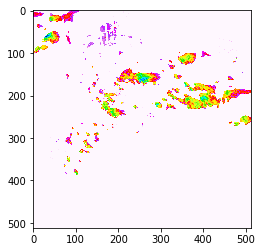

↓↓↓下面的是模型的1输出，上面的是1真实值↑↑↑


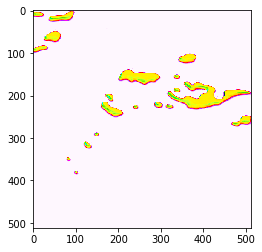

In [60]:
plt.imshow(a.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的%d输出，上面的是%d真实值↑↑↑' % (1, 1))
plt.imshow(b.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()

In [ ]:
input_shape = list(model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))

In [23]:
print(x_matrix.shape)
print(y_matrix.shape)
print(a.shape)

(1, 10, 512, 512, 1)
(1, 10, 512, 512, 1)
(512, 512, 1)


In [19]:
print(model.get_input_shape_at(0))
print(model.get_output_shape_at(0))

(None, 10, 512, 512, 1)
(None, 512, 512, 1)
